Random Forest experiment with MLflow tracking

In [13]:
#!pip install mlflow
#!pip install imbalanced-learn mlflow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, recall_score, f1_score, precision_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import joblib
from sklearn.ensemble import RandomForestClassifier
import mlflow
import mlflow.sklearn
import warnings
warnings.filterwarnings("ignore")

In [2]:
%cd /home/jovyan/

/home/jovyan


In [3]:
# Data Loading and Preprocessing
df = pd.read_csv("work/notebook_experiments/healthcare-dataset-stroke-data.csv")

In [4]:
# Data Cleaning
df["bmi"] = df["bmi"].fillna(df["bmi"].median())
df = df[df['gender'] != 'Other']

In [5]:
# Feature Selection
selected_features = ['gender', 'age', 'hypertension', 'heart_disease',
                    'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']
df = df[selected_features]

In [6]:
# Feature Engineering
df_fe = df.copy()
# 1. Age Grouping
age_bins = [0, 50, 80, 120]
age_labels = ['Young adult', 'Middle-aged', 'Very old']
df_fe['age_group'] = pd.cut(df_fe['age'], bins=age_bins, labels=age_labels, right=False)

# 2. BMI Categories
bmi_bins = [0, 18.5, 25, 30, 35, 40, 100]
bmi_labels = ['Underweight', 'Healthy Weight', 'Overweight', 'Class 1 Obesity', 'Class 2 Obesity', 'Class 3 Obesity']
df_fe['bmi_category'] = pd.cut(df_fe['bmi'], bins=bmi_bins, labels=bmi_labels, right=False)

# 3. Interaction Feature
df_fe['age_hypertension'] = df_fe['age'] * df_fe['hypertension']

# 4. Glucose Level Binning
glucose_bins = [0, 70, 85, 100, 110, 126, 140, 300]
glucose_labels = ['Hypoglycemia', 'Low Normal', 'Normal', 'Elevated', 'Pre-diabetic', 'Borderline Diabetic', 'Diabetic']
df_fe['glucose_category'] = pd.cut(df_fe['avg_glucose_level'], bins=glucose_bins, labels=glucose_labels, right=False)


In [7]:
# Defining categorical and numerical columns
categorical_cols = ['gender', 'smoking_status','age_group', 'bmi_category', 'glucose_category']
numerical_cols = [col for col in df_fe.columns if col not in categorical_cols + ['stroke']]

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore')),
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [8]:
# Train-test split
X = df_fe.drop(columns=['stroke'])
y = df_fe['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# MLflow Experiment
mlflow.set_experiment("Stroke_Prediction_RandomForest")
mlflow.set_tracking_uri("http://45.151.153.107:5000")

2025/06/19 19:38:27 INFO mlflow.tracking.fluent: Experiment with name 'Stroke_Prediction_RandomForest' does not exist. Creating a new experiment.


2025/06/19 19:38:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Random Forest ---
              precision    recall  f1-score   support

           0     0.9549    0.8812    0.9166       960
           1     0.1618    0.3548    0.2222        62

    accuracy                         0.8493      1022
   macro avg     0.5583    0.6180    0.5694      1022
weighted avg     0.9067    0.8493    0.8745      1022

ROC-AUC: 0.8067540322580645
🏃 View run Stroke_Prediction_RandomForest_v1 at: http://45.151.153.107:5000/#/experiments/3/runs/42e8f81e57a14de291f05824dce70bdb
🧪 View experiment at: http://45.151.153.107:5000/#/experiments/3


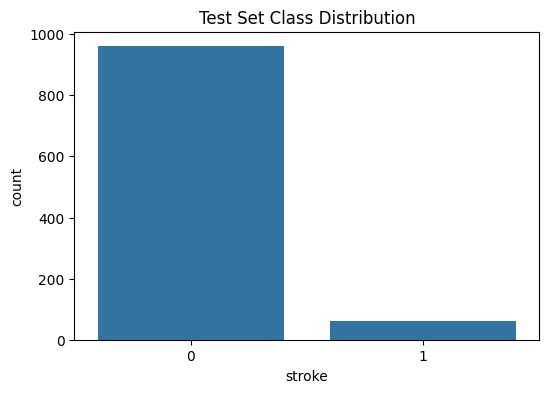

In [11]:
with mlflow.start_run(run_name="Stroke_Prediction_RandomForest_v1"):
    # Define and train model
    rf_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_split=5,
            random_state=42
        ))
    ])

    mlflow.set_tag("mlflow.user", "Thato")

    rf_pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred_rf = rf_pipeline.predict(X_test)
    y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_rf)
    precision = precision_score(y_test, y_pred_rf, zero_division=0)
    recall = recall_score(y_test, y_pred_rf)
    f1 = f1_score(y_test, y_pred_rf)
    roc_auc = roc_auc_score(y_test, y_proba_rf)

    # Log parameters
    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("min_samples_split", 5)

    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_auc", roc_auc)

    # Log model
    mlflow.sklearn.log_model(rf_pipeline, "random_forest_model")

    # Save model locally
    joblib.dump(rf_pipeline, "Random_Forest.pkl")

    # Print results
    print("--- Random Forest ---")
    print(classification_report(y_test, y_pred_rf, digits=4))
    print("ROC-AUC:", roc_auc)

    # Log artifacts (plots)
    plt.figure(figsize=(6, 4))
    sns.countplot(x=y_test)
    plt.title('Test Set Class Distribution')
    plt.savefig("class_distribution.png")
    mlflow.log_artifact("class_distribution.png")

    # Confusion Matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(y_test, y_pred_rf)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Stroke", "Stroke"])
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap="Blues", values_format='d')
    plt.title("Confusion Matrix: Random Forest")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

In [11]:
!ls

healthcare-dataset-stroke-data.csv
LightGBM_StrokePrediction_MLflow.ipynb
LogisticRegression_StrokePrediction_MLflow.ipynb
mlruns
RandomForest_StrokePrediction_MLflow.ipynb
SVM_StrokePrediction_MLflow.ipynb
XGBoost_StrokePrediction_MLflow.ipynb


In [23]:
artifact_uri = mlflow.get_artifact_uri()

In [24]:
artifact_uri

'file:///mlflow/mlruns/5/3cf963f0620d407d84ccd4e5e53df658/artifacts'

In [7]:
!pwd

/home/jovyan


In [8]:
!ls

work
